Los datos que usará google colab. La información está en:

1. new_base_dir almacena el path de la BD reducida con la que se entrenará en este ejemplo. Dentro debe tener tres carpetas: train, test y validation y dentro de cada una, dos carpetas: Manga y Comic


In [ ]:
!pip install gdown #Instala una librería para descargar archivos de Google Drive
#https://drive.google.com/file/d/16CqNKV7cMVC_-QvAb1ufojUhWAceCuU7/view?usp=sharing
!gdown --id 16CqNKV7cMVC_-QvAb1ufojUhWAceCuU7 #Descarga el daataset que está en el Drive del Prof. Toro
!unzip manga_comic.zip #Descomprime el archivo del dataset
from IPython.display import Image #Librería para visualizar imágenes en Jupyter
new_base_dir=r"manga_comic"


Se han truncado las últimas 5000 líneas del flujo de salida.
 extracting: manga_comic/train/Comic/1848.png  
 extracting: manga_comic/train/Comic/1849.png  
  inflating: manga_comic/train/Comic/185.png  
 extracting: manga_comic/train/Comic/1850.png  
 extracting: manga_comic/train/Comic/1851.png  
 extracting: manga_comic/train/Comic/1852.png  
 extracting: manga_comic/train/Comic/1853.png  
 extracting: manga_comic/train/Comic/1854.png  
 extracting: manga_comic/train/Comic/1855.png  
 extracting: manga_comic/train/Comic/1856.png  
 extracting: manga_comic/train/Comic/1857.png  
 extracting: manga_comic/train/Comic/1858.png  
 extracting: manga_comic/train/Comic/1859.png  
 extracting: manga_comic/train/Comic/186.png  
 extracting: manga_comic/train/Comic/1860.png  
  inflating: manga_comic/train/Comic/1861.png  
 extracting: manga_comic/train/Comic/1862.png  
 extracting: manga_comic/train/Comic/1863.png  
 extracting: manga_comic/train/Comic/1864.png  
 extracting: manga_comic/trai

Visualizar una imagen

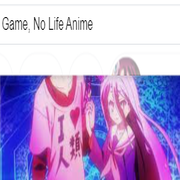

In [ ]:
display(Image(filename="manga_comic/train/Manga/1005.png"))

Definición de la red neuronal de 1 neurona para imagénes de 180x180 píxeles

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
#x = layers.Rescaling(1./255)(x)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
#x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
#x = layers.MaxPooling2D(pool_size=2)(x)
#x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
#x = layers.MaxPooling2D(pool_size=2)(x)
#x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
#x = layers.MaxPooling2D(pool_size=2)(x)
#x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
#x = layers.MaxPooling2D(pool_size=2)(x)
#x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
#x = layers.Flatten()(x)
#x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_11 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem_2   (None, 180, 180, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d_6   (None, 512)              0  

Hiperparámetros para el entrenamiento y medición de desempeño

In [ ]:
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Convierte la información de la imagen de píxeles en un tensor numérico de punto flotante y ajusta el tamaño de la imagen porque todas tienen diferente resolución

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"train",
    image_size=(180, 180),
    batch_size=64)
validation_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"validation",
    image_size=(180, 180),
    batch_size=64)
test_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"test",
    image_size=(180, 180),
    batch_size=64)

Found 3942 files belonging to 2 classes.
Found 1990 files belonging to 2 classes.
Found 2649 files belonging to 2 classes.


Extrayendo las características de los conjuntos de entrenamiento, validación y prueba con sus etiquetas

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        all_features.append(images)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

print(test_features.shape)
print(test_labels.shape)

(2649, 180, 180, 3)
(2649,)


Fase de entrenamiento 

In [ ]:
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset)

Epoch 1/20
62/62 [==============================] - 22s 349ms/step - loss: 0.2733 - accuracy: 0.8914 - val_loss: 0.3099 - val_accuracy: 0.8714
Epoch 2/20
62/62 [==============================] - 22s 345ms/step - loss: 0.2732 - accuracy: 0.8871 - val_loss: 0.3083 - val_accuracy: 0.8729
Epoch 3/20
62/62 [==============================] - 22s 346ms/step - loss: 0.2679 - accuracy: 0.8929 - val_loss: 0.3123 - val_accuracy: 0.8714
Epoch 4/20
62/62 [==============================] - 22s 344ms/step - loss: 0.2765 - accuracy: 0.8828 - val_loss: 0.3132 - val_accuracy: 0.8724
Epoch 5/20
62/62 [==============================] - 22s 350ms/step - loss: 0.2698 - accuracy: 0.8879 - val_loss: 0.3115 - val_accuracy: 0.8754
Epoch 6/20
62/62 [==============================] - 22s 343ms/step - loss: 0.2786 - accuracy: 0.8864 - val_loss: 0.3082 - val_accuracy: 0.8734
Epoch 7/20
62/62 [==============================] - 22s 349ms/step - loss: 0.2734 - accuracy: 0.8858 - val_loss: 0.3032 - val_accuracy: 0.8749

Visualización de la pérdidad y el accuracy tanto para los datos de entrenamiento como para los datos de validación y así detectar si hay overfitting

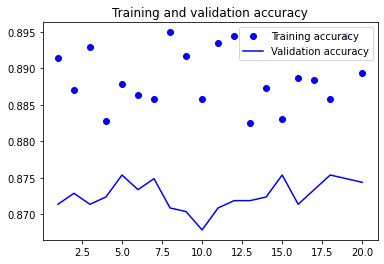

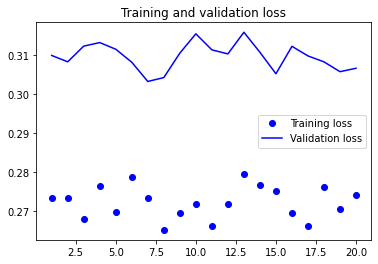

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Matriz de confusión

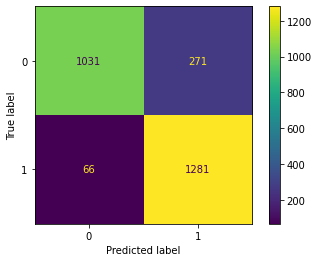

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
test_predictions = model.predict(test_features)
cm = confusion_matrix(test_labels, test_predictions > 0.5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Cálculo de la exactitud (en inglés, *accurracy*)

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(test_labels, test_predictions > 0.5))

0.8727821819554549


Ejercicio:
----------
1. Desarrollar un modelo que tenga la mejor exactitud (en inglés, *accurracy*) posible en el conjunto de prueba (en inglés, *test*). Para lograrlo, hay que hacer un entrenamiento sin sobreajustar (en inglés, *overfit*)